In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
import pyarrow.parquet as pa
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
df = pd.read_parquet('data/all_data.parquet')
df.shape

(519766, 18)

In [3]:
df.columns

Index(['Время', 'Мощность МПСИ', 'Мощность МШЦ', 'Ток МПСИ', 'Ток МШЦ',
       'Питание МПСИ', 'Возврат руды МПСИ', 'Расход воды МПСИ PV',
       'Расход воды МПСИ SP', 'Расход воды МПСИ CV',
       'факт соотношение руда/вода МПСИ',
       'Давление на подшипник МПСИ загрузка',
       'Давление на подшипник МПСИ разгрузка', 'Расход оборотной воды',
       'pH оборотной воды', 't оборотной воды', 'Гранулометрия', 'Поток'],
      dtype='object')

##  Предобработка данных

Text(0.5, 1.0, 'Корреляция параметров')

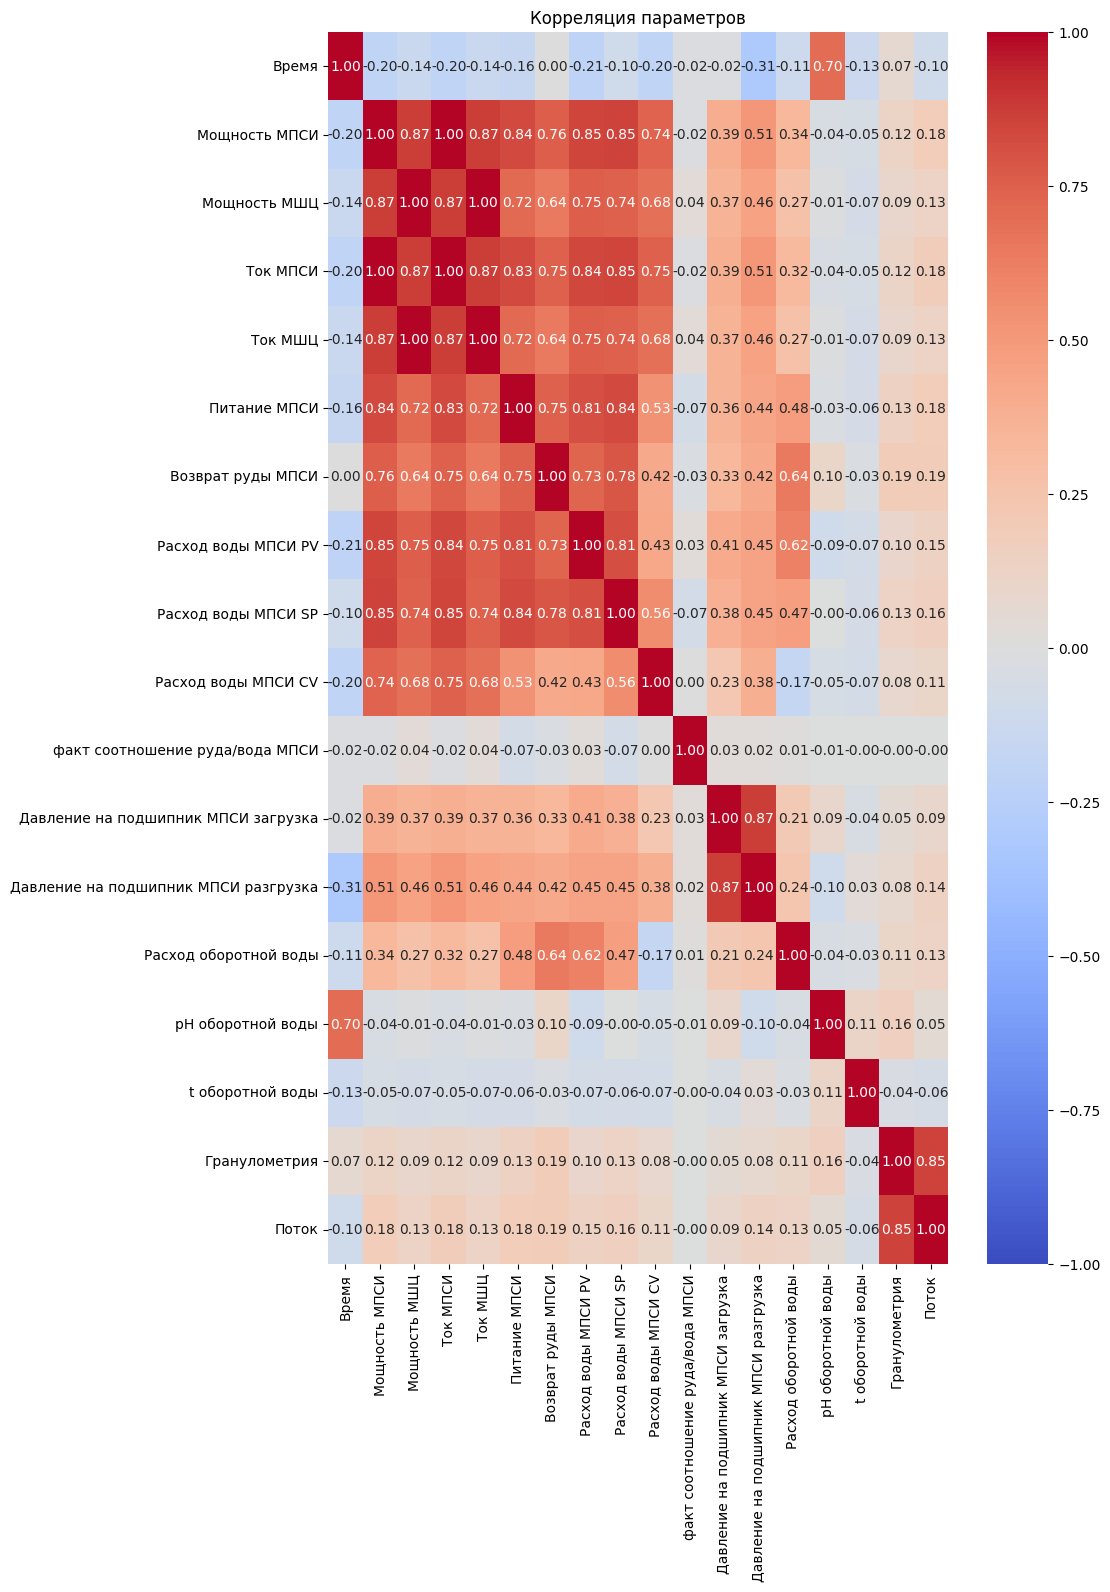

In [4]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 16))

sns.heatmap(correlation_matrix, 
            annot=True,           # Показывать значения
            fmt='.2f',            # Формат чисел (2 десятичных знака)
            cmap='coolwarm',      # Цветовая схема
            center=0,             # Центр цветовой шкалы
            vmin=-1,              # Минимальное значение
            vmax=1)        

plt.title('Корреляция параметров')

In [5]:
correlation_matrix['Гранулометрия'].sort_values(ascending=False)

Гранулометрия                           1.000000
Поток                                   0.854900
Возврат руды МПСИ                       0.190807
pH оборотной воды                       0.159022
Питание МПСИ                            0.134301
Расход воды МПСИ SP                     0.130731
Мощность МПСИ                           0.118232
Ток МПСИ                                0.117085
Расход оборотной воды                   0.106756
Расход воды МПСИ PV                     0.095634
Мощность МШЦ                            0.086049
Ток МШЦ                                 0.086034
Расход воды МПСИ CV                     0.081383
Давление на подшипник МПСИ разгрузка    0.076063
Время                                   0.065820
Давление на подшипник МПСИ загрузка     0.052566
факт соотношение руда/вода МПСИ        -0.001212
t оборотной воды                       -0.035507
Name: Гранулометрия, dtype: float64

### 1. Количество пустых значений в начальном датасете

In [6]:
print(df.isna().sum(axis=0))

print(f'\n\nПроцентное соотношение пропусков: {df.isna().sum(axis=0).max()/len(df)*100}%')

Время                                       0
Мощность МПСИ                              32
Мощность МШЦ                               32
Ток МПСИ                                   32
Ток МШЦ                                    32
Питание МПСИ                               32
Возврат руды МПСИ                          32
Расход воды МПСИ PV                        32
Расход воды МПСИ SP                        32
Расход воды МПСИ CV                        32
факт соотношение руда/вода МПСИ            32
Давление на подшипник МПСИ загрузка        32
Давление на подшипник МПСИ разгрузка       32
Расход оборотной воды                      32
pH оборотной воды                          32
t оборотной воды                           32
Гранулометрия                              32
Поток                                   16051
dtype: int64


Процентное соотношение пропусков: 3.0881204234213087%


# Анализ Потока

В нашем датасете есть **176413** строчек, где Поток = 0

In [7]:
is_potok0 = (df['Поток'] == 0).values
potok0_inds = [ i for i in range(len(is_potok0)) if is_potok0[i] ]
len(potok0_inds)

176413

При потоке=0 мы видим, что 176411 значений Гранулометрии = 0, что составляет **99.998%**, значит в этот момент ничего не работало, можем удалить эти строчки

In [8]:
cnt_gralunometr0_potok0 = 0

for ind in potok0_inds:
    if df['Гранулометрия'][ind] == 0:
        cnt_gralunometr0_potok0 += 1

print(cnt_gralunometr0_potok0)
f'Соотношение Гранулометрии = 0 при Потоке = 0: {cnt_gralunometr0_potok0/len(potok0_inds)*100}%'



176411


'Соотношение Гранулометрии = 0 при Потоке = 0: 99.9988662967015%'

In [9]:
print('длина до удаления строк с Потоком = 0:', df.shape)
df.drop(potok0_inds, inplace=True)
print('длина после удаления строк с Потоком = 0:', df.shape)

длина до удаления строк с Потоком = 0: (519766, 18)
длина после удаления строк с Потоком = 0: (343353, 18)


Продолжаем анализировать наши данные потока, сделаем гистограмму распределения потока

Text(0, 0.5, 'Частота')

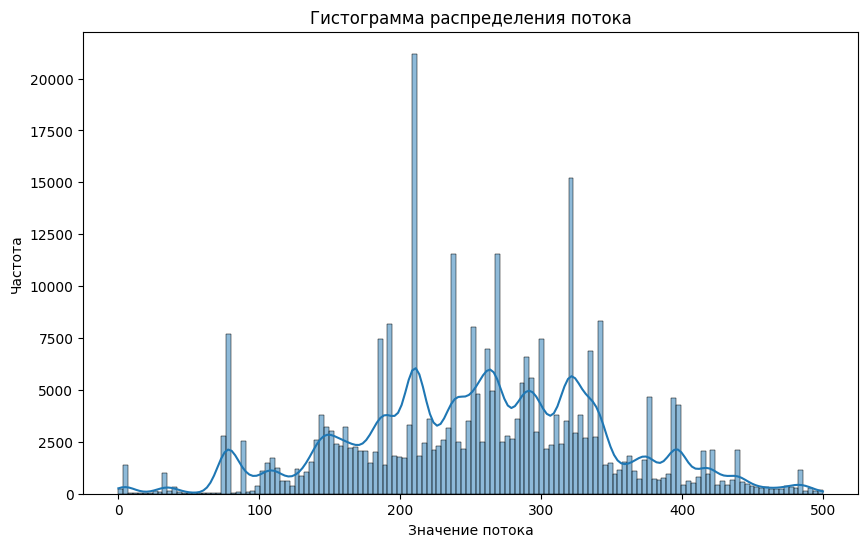

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(data=df, x='Поток', kde=True, ax=axes)
axes.set_title('Гистограмма распределения потока')
axes.set_xlabel('Значение потока')
axes.set_ylabel('Частота')

Есть 16051 пропущенных значений потока, попробуем восстановить их с помощью медианы

In [11]:
df['Поток'].isna().sum()

16051

In [12]:
df['Поток'] = df['Поток'].fillna(df['Поток'].median())

Посмотрим на новую гистограмму распределения потока, уже выглядит получше

Text(0, 0.5, 'Частота')

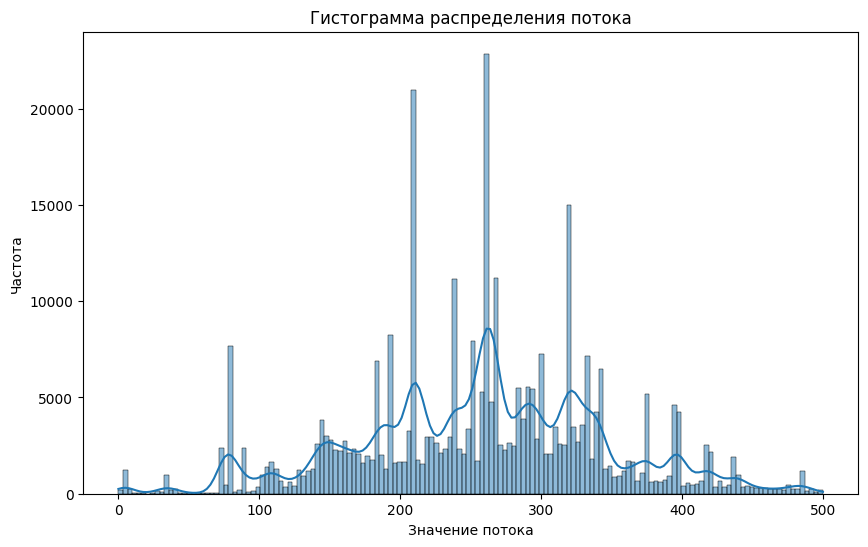

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(data=df, x='Поток', kde=True, ax=axes)
axes.set_title('Гистограмма распределения потока')
axes.set_xlabel('Значение потока')
axes.set_ylabel('Частота')

Теперь узнаем какие параметры сильно коррелируют между собой

Text(0.5, 1.0, 'Корреляция параметров')

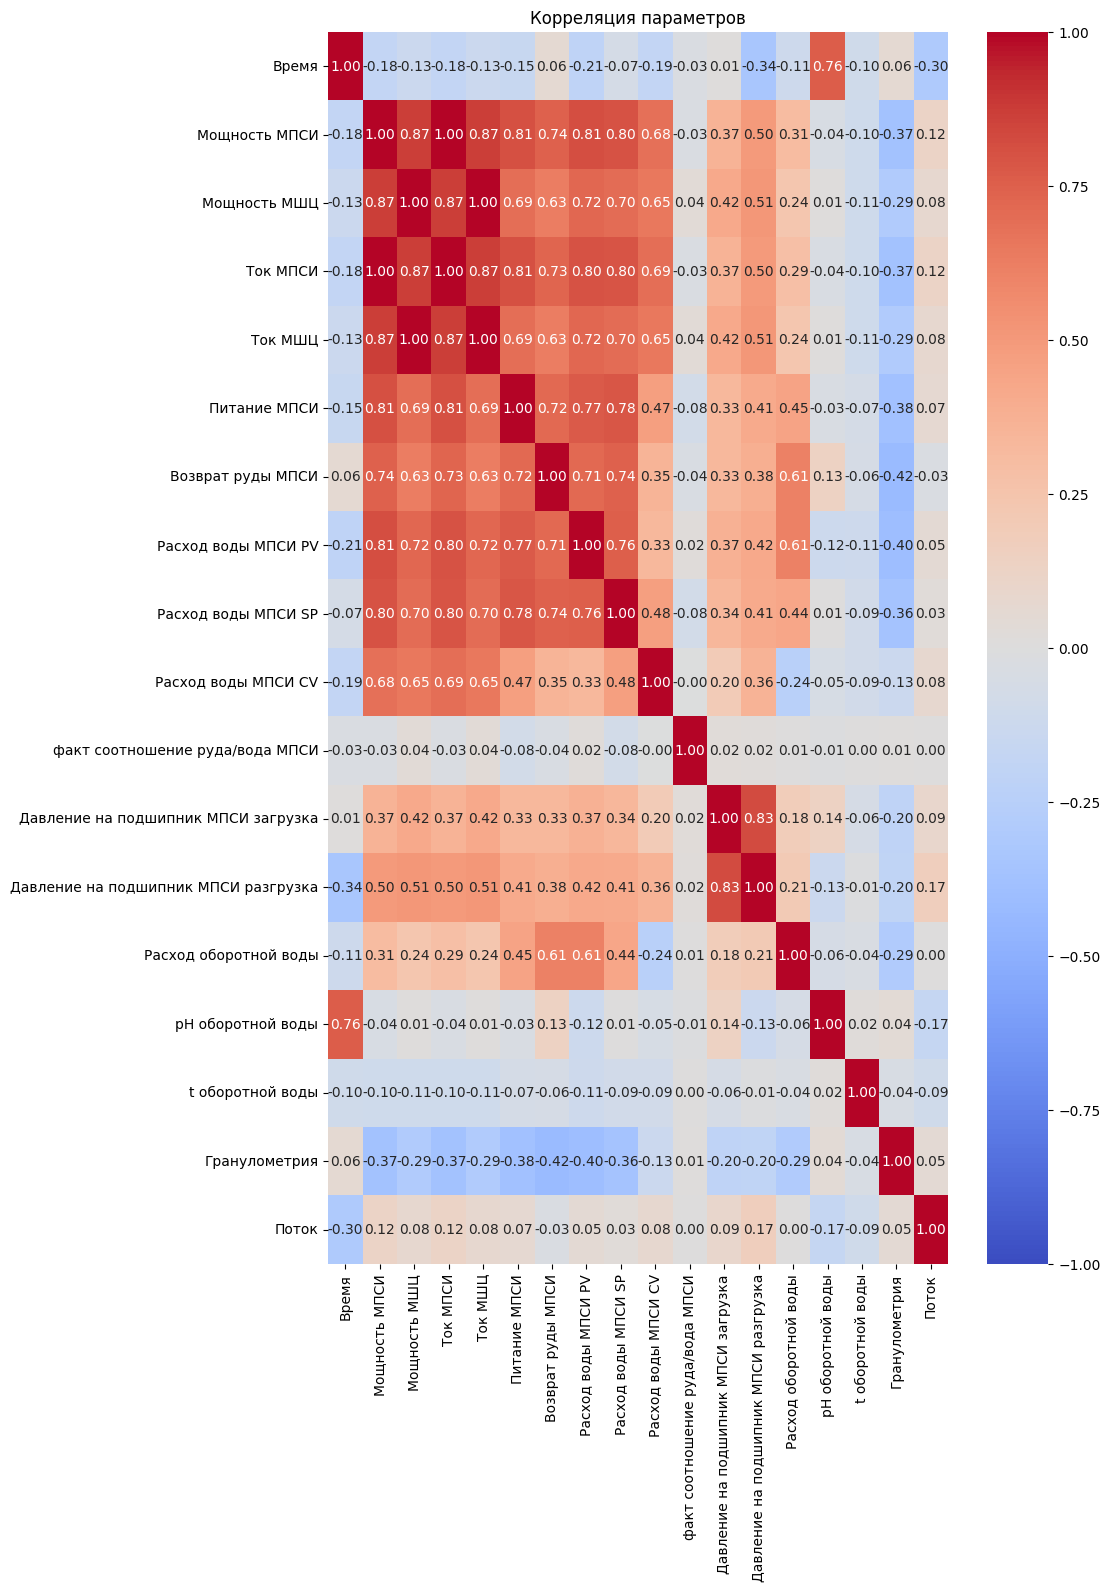

In [14]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 16))

sns.heatmap(correlation_matrix, 
            annot=True,           # Показывать значения
            fmt='.2f',            # Формат чисел (2 десятичных знака)
            cmap='coolwarm',      # Цветовая схема
            center=0,             # Центр цветовой шкалы
            vmin=-1,              # Минимальное значение
            vmax=1)        

plt.title('Корреляция параметров')

### Создаем подграфики для разных типов визуализации

Text(0, 0.5, 'Значение потока')

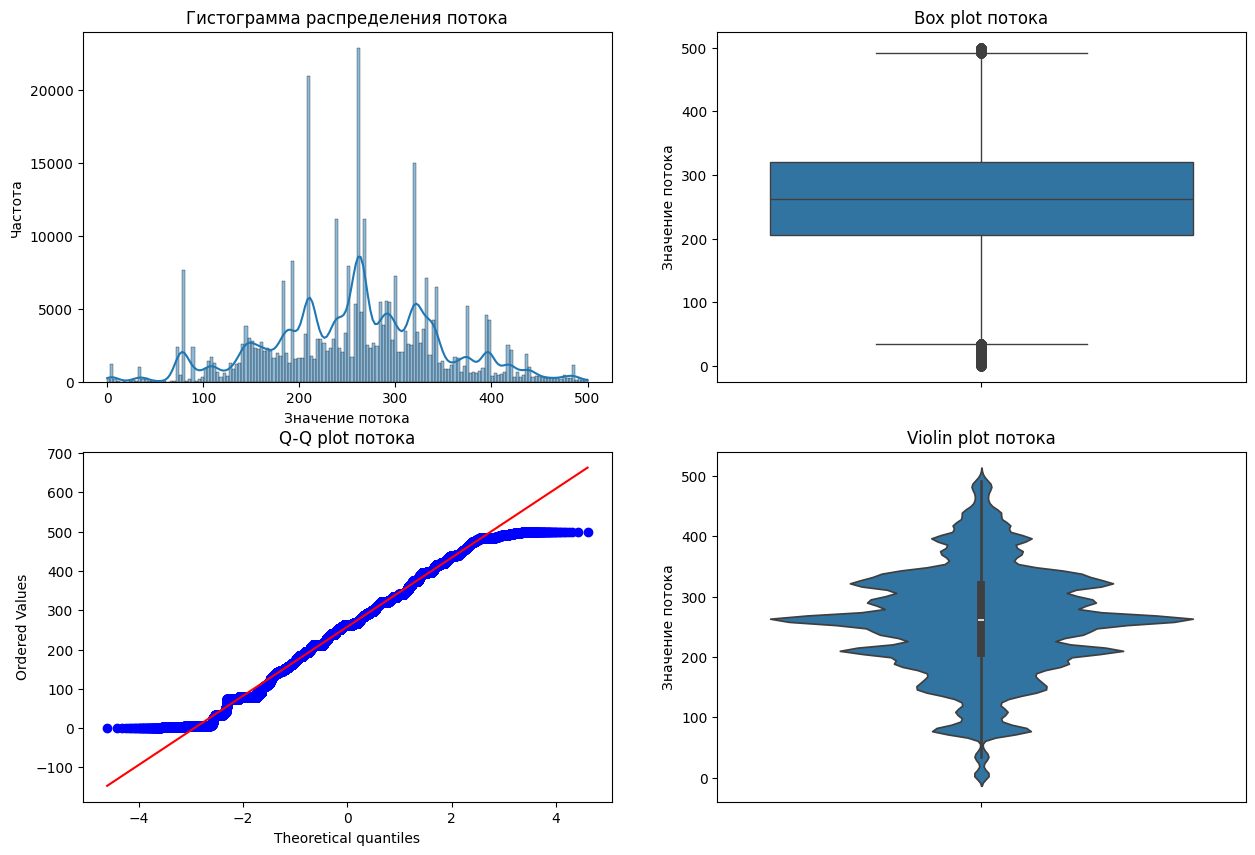

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Гистограмма с кривой плотности
sns.histplot(data=df, x='Поток', kde=True, ax=axes[0,0])
axes[0,0].set_title('Гистограмма распределения потока')
axes[0,0].set_xlabel('Значение потока')
axes[0,0].set_ylabel('Частота')

# (Box plot)
sns.boxplot(data=df, y='Поток', ax=axes[0,1])
axes[0,1].set_title('Box plot потока')
axes[0,1].set_ylabel('Значение потока')

# QQ-plot для проверки на нормальность
stats.probplot(df['Поток'].dropna(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q plot потока')

# Violin plot
sns.violinplot(data=df, y='Поток', ax=axes[1,1])
axes[1,1].set_title('Violin plot потока')
axes[1,1].set_ylabel('Значение потока')


# Создаем график зависимости гранулометрии от потока

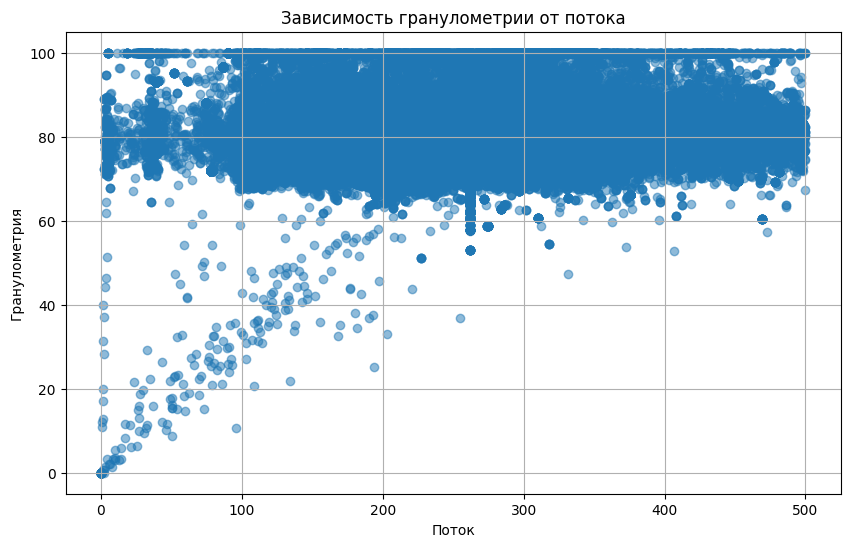

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Поток'], df['Гранулометрия'], alpha=0.5)
plt.title('Зависимость гранулометрии от потока')
plt.xlabel('Поток')
plt.ylabel('Гранулометрия')
plt.grid(True)


### Вывод основных статистик

In [17]:
print("\nОсновные статистические показатели потока:")
print(df['Поток'].describe())


Основные статистические показатели потока:
count    343353.000000
mean        257.991572
std          88.086234
min           0.002083
25%         205.709961
50%         261.926361
75%         319.938293
max         499.989227
Name: Поток, dtype: float64


### Расчет асимметрии и эксцесса


In [18]:
print("\nДополнительные характеристики распределения:")
print(f"Асимметрия: {df['Поток'].skew():.3f}")
print(f"Эксцесс: {df['Поток'].kurtosis():.3f}")


Дополнительные характеристики распределения:
Асимметрия: -0.095
Эксцесс: 0.018


### Определение выбросов методом межквартильного размаха

In [19]:
Q1 = df['Поток'].quantile(0.25)
Q3 = df['Поток'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Поток'] < lower_bound) | (df['Поток'] > upper_bound)]['Поток']
print(f"\nКоличество выбросов: {len(outliers)}")
print(f"Процент выбросов: {(len(outliers)/len(df['Поток'])*100):.2f}%")
print(f"Нижняя граница выбросов: {lower_bound:.2f}")
print(f"Верхняя граница выбросов: {upper_bound:.2f}")


Количество выбросов: 3319
Процент выбросов: 0.97%
Нижняя граница выбросов: 34.37
Верхняя граница выбросов: 491.28


### График плотности с выбросами

Text(0.5, 1.0, 'Распределение потока с границами выбросов')

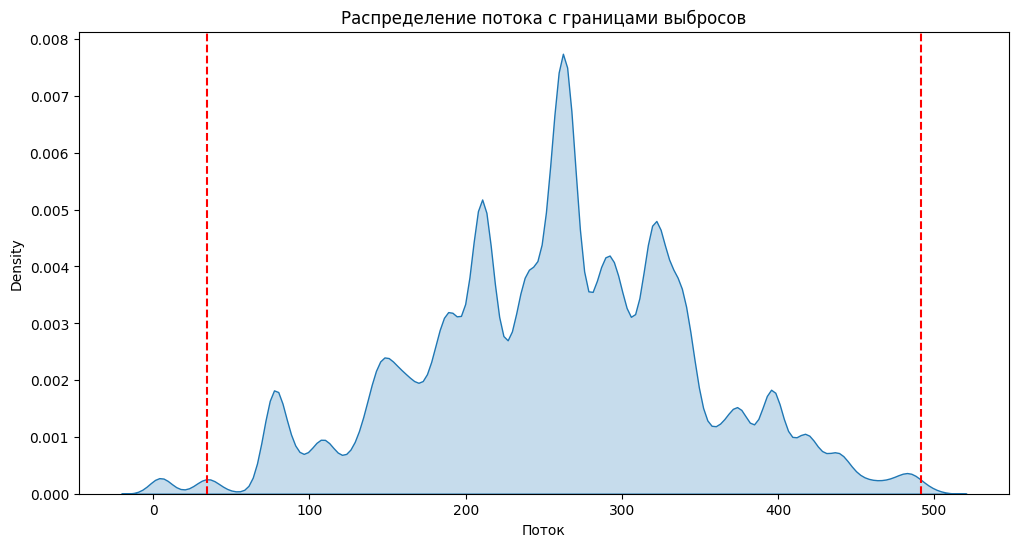

In [20]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Поток', fill=True)
plt.axvline(x=lower_bound, color='r', linestyle='--', label='Границы выбросов')
plt.axvline(x=upper_bound, color='r', linestyle='--')
plt.title('Распределение потока с границами выбросов')

#### В тесте на нормальное распределение мы заметили, что распределение значительно отличается от нормального, поэтому попробуем различные способы преобразования данных

#### 1. Исходные данные


Исходные данные:
p-value: 0.0000000000


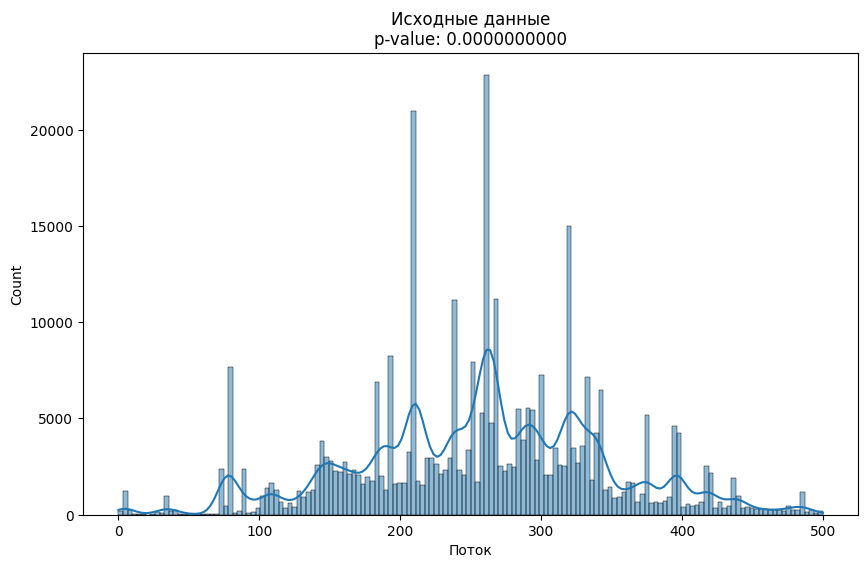

In [21]:
original_pvalue = stats.normaltest(df['Поток'].dropna())[1]
print("\nИсходные данные:")
print(f"p-value: {original_pvalue:.10f}")

plt.figure(figsize=(10, 6))
sns.histplot(df['Поток'], kde=True)
plt.title(f'Исходные данные\np-value: {original_pvalue:.10f}')
plt.show()

#### 1. Логарифмическое преобразование


Логарифмическое преобразование:
p-value: 0.0000000000


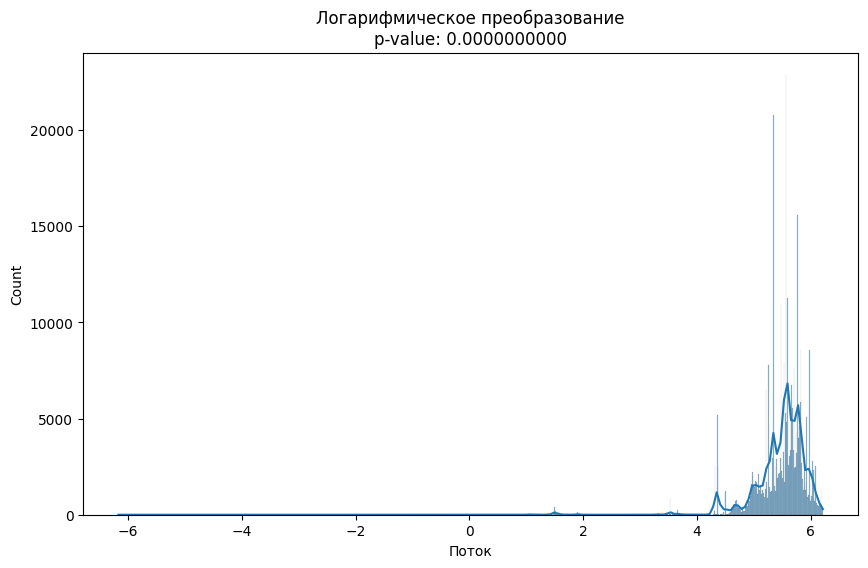

In [22]:
log_data = np.log(df['Поток'])
log_pvalue = stats.normaltest(log_data.dropna())[1]
print("\nЛогарифмическое преобразование:")
print(f"p-value: {log_pvalue:.10f}")
    
plt.figure(figsize=(10, 6))
sns.histplot(log_data, kde=True)
plt.title(f'Логарифмическое преобразование\np-value: {log_pvalue:.10f}')
plt.show()

#### 2. Квадратный корень


Преобразование квадратным корнем:
p-value: 0.0000000000


Text(0.5, 1.0, 'Преобразование квадратным корнем\np-value: 0.0000000000')

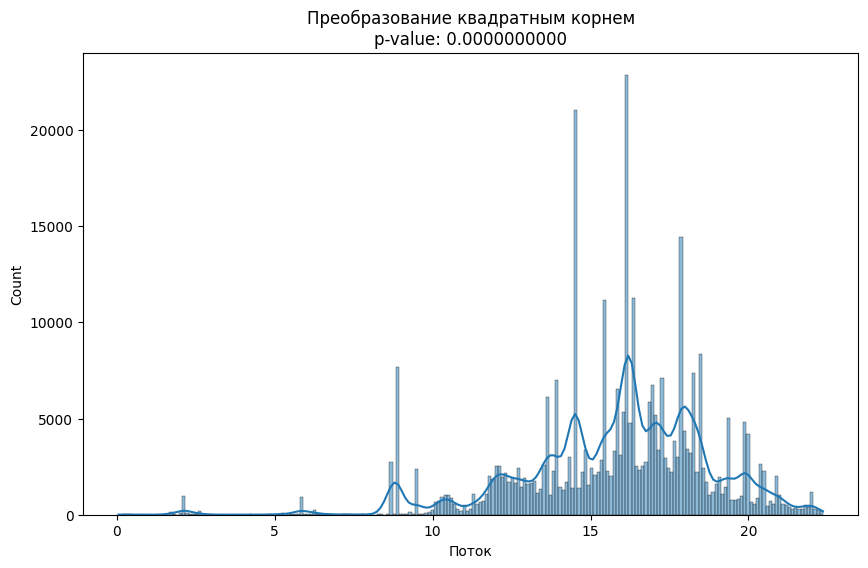

In [23]:
sqrt_data = np.sqrt(df['Поток'])
sqrt_pvalue = stats.normaltest(sqrt_data.dropna())[1]
print("\nПреобразование квадратным корнем:")
print(f"p-value: {sqrt_pvalue:.10f}")

plt.figure(figsize=(10, 6))
sns.histplot(sqrt_data, kde=True)
plt.title(f'Преобразование квадратным корнем\np-value: {sqrt_pvalue:.10f}')

#### 3. Box-Cox преобразование


Box-Cox преобразование:
p-value: 0.0000000000
lambda: 1.0358


Text(0.5, 1.0, 'Box-Cox преобразование\np-value: 0.0000000000')

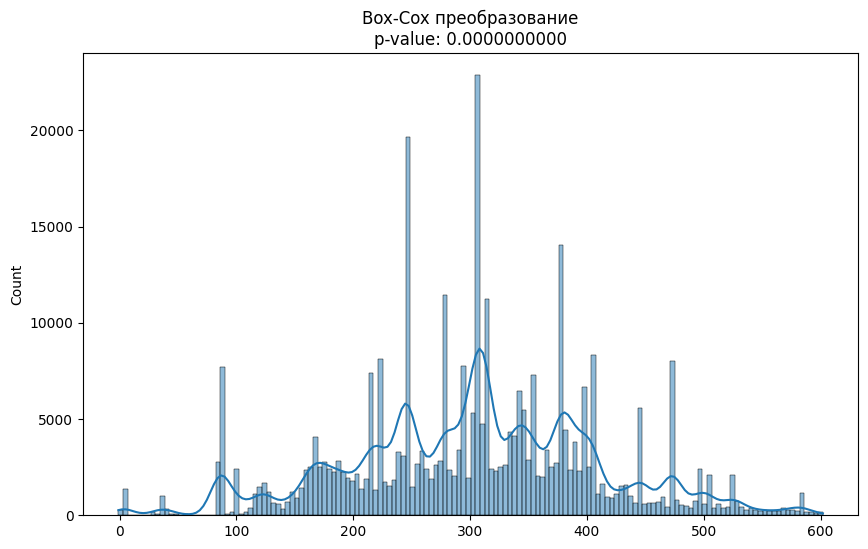

In [24]:
boxcox_data, lambda_param = stats.boxcox(df['Поток'])
boxcox_pvalue = stats.normaltest(boxcox_data)[1]
print("\nBox-Cox преобразование:")
print(f"p-value: {boxcox_pvalue:.10f}")
print(f"lambda: {lambda_param:.4f}")
    
plt.figure(figsize=(10, 6))
sns.histplot(boxcox_data, kde=True)
plt.title(f'Box-Cox преобразование\np-value: {boxcox_pvalue:.10f}')

#### 4. Yeo-Johnson преобразование


Yeo-Johnson преобразование:
p-value: 0.0000000000
lambda: 1.0403


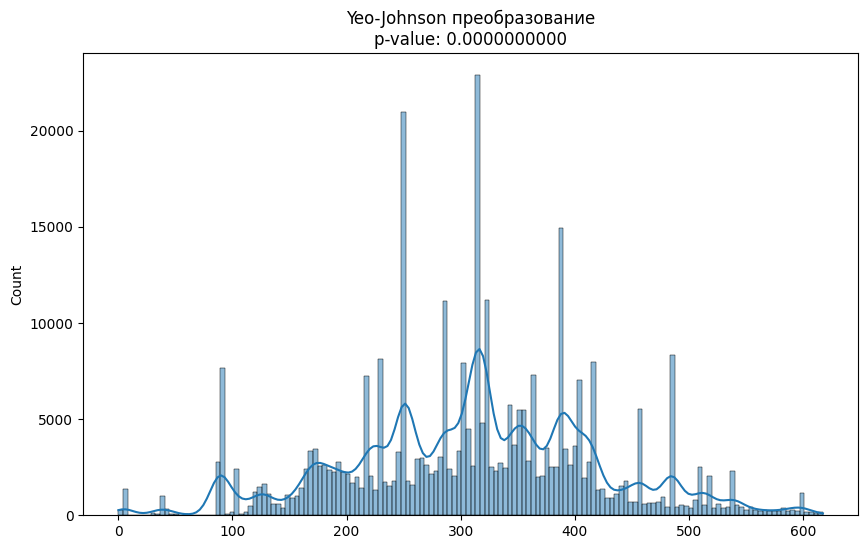

In [25]:
yeojohnson_data, lambda_param = stats.yeojohnson(df['Поток'])
yeojohnson_pvalue = stats.normaltest(yeojohnson_data)[1]
print("\nYeo-Johnson преобразование:")
print(f"p-value: {yeojohnson_pvalue:.10f}")
print(f"lambda: {lambda_param:.4f}")

plt.figure(figsize=(10, 6))
sns.histplot(yeojohnson_data, kde=True)
plt.title(f'Yeo-Johnson преобразование\np-value: {yeojohnson_pvalue:.10f}')
plt.show()

Text(0.5, 1.0, 'Робастное масштабирование')

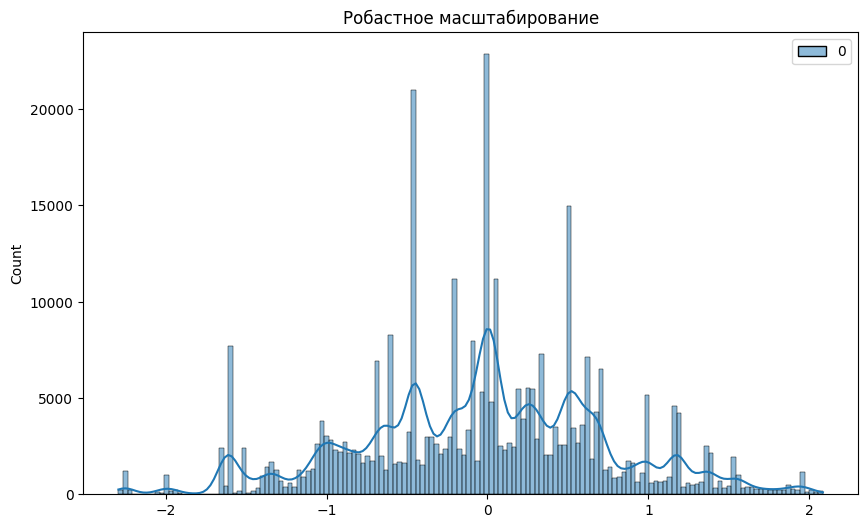

In [26]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(df[['Поток']])
scaled_pvalue = stats.normaltest(scaled_data)[1]

plt.figure(figsize=(10, 6))
sns.histplot(scaled_data, kde=True)
plt.title('Робастное масштабирование')

#### 6. Обработка выбросов методом IQR

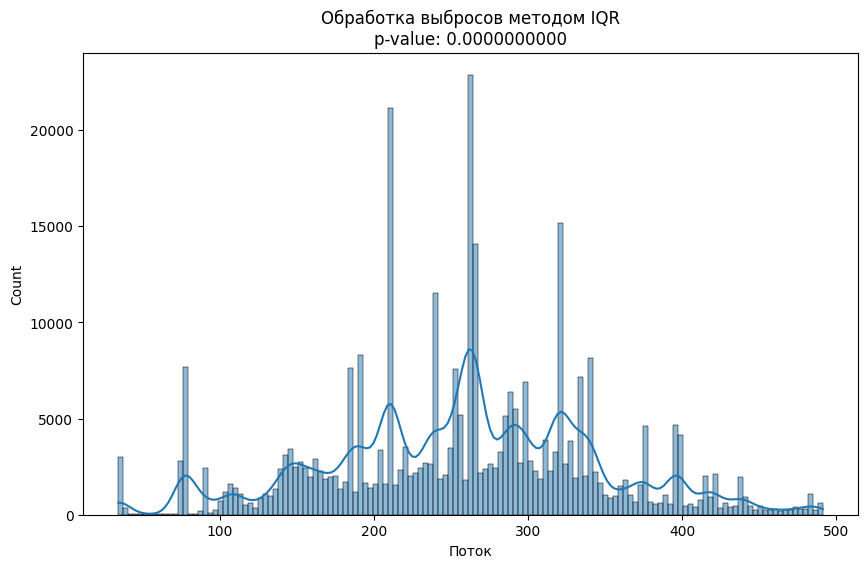

In [27]:
Q1 = df['Поток'].quantile(0.25)
Q3 = df['Поток'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

cleaned_data_iqr = df['Поток'].clip(lower_bound, upper_bound)
cleaned_iqr_pvalue = stats.normaltest(cleaned_data_iqr)[1]

plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data_iqr, kde=True)
plt.title(f'Обработка выбросов методом IQR\np-value: {cleaned_iqr_pvalue:.10f}')
plt.show()

#### 7. Обработка выбросов методом z-score

Text(0.5, 1.0, 'Обработка выбросов методом Z-score\np-value: 0.0000000000')

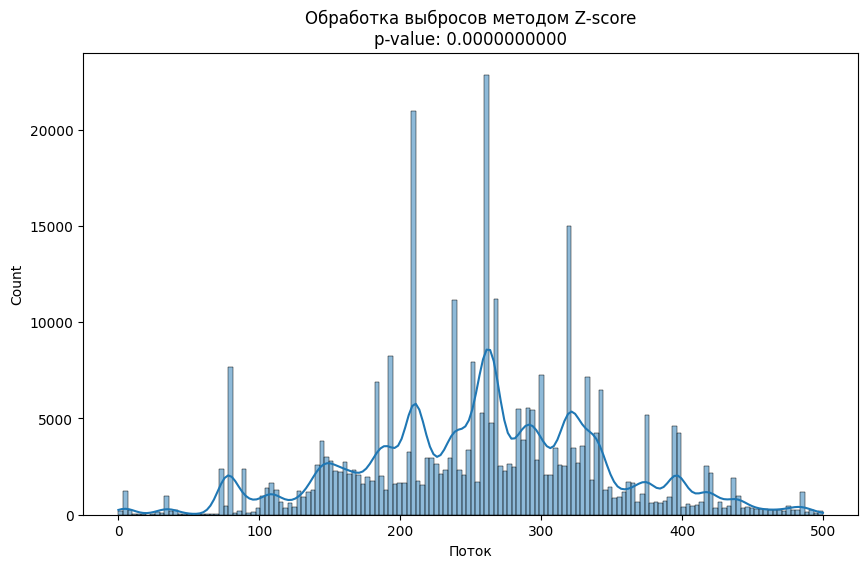

In [28]:
z_scores = np.abs(stats.zscore(df['Поток']))
cleaned_data_zscore = df['Поток'].mask(z_scores > 3, df['Поток'].median())
cleaned_zscore_pvalue = stats.normaltest(cleaned_data_zscore)[1]

plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data_zscore, kde=True)
plt.title(f'Обработка выбросов методом Z-score\np-value: {cleaned_zscore_pvalue:.10f}')

### Сравнение результатов всех методов

In [29]:
results = {
    'Исходные данные': original_pvalue,
    'Логарифм': log_pvalue if df['Поток'].min() > 0 else None,
    'Квадратный корень': sqrt_pvalue if df['Поток'].min() > 0 else None,
    'Box-Cox': boxcox_pvalue if df['Поток'].min() > 0 else None,
    'Yeo-Johnson': yeojohnson_pvalue,
    'Робастное масштабирование': scaled_pvalue,
    'IQR': cleaned_iqr_pvalue,
    'Z-score': cleaned_zscore_pvalue
}


# Определение лучшего метода
best_method = max(results.items(), key=lambda x: x[1] if x[1] is not None else -np.inf)
print(f"\nЛучший метод: {best_method[0]} (p-value: {best_method[1]:.10f})")

if best_method[1] < 0.05:
    print("\nРаспределение все еще не нормальное. Рекомендуется использовать непараметрические методы.")
else:
    print("\nУспешная нормализация данных.")


Лучший метод: Yeo-Johnson (p-value: 0.0000000000)

Распределение все еще не нормальное. Рекомендуется использовать непараметрические методы.


## p values равно 0 я хз что с этим делать

# Оценка важности параметров для предсказания Гранулометрии

In [30]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [31]:
df = df.dropna()
df["Гранулометрия"].isna().sum()

0

In [32]:
# Преобразуем столбец 'Время' в datetime
df['Время'] = pd.to_datetime(df['Время'])

In [33]:
# Добавим дополнительные временные признаки
df['Час'] = df['Время'].dt.hour
df['День'] = df['Время'].dt.day
df['Месяц'] = df['Время'].dt.month
df['День_недели'] = df['Время'].dt.dayofweek

In [34]:
X = df.drop(['Гранулометрия'], axis=1)
y = df['Гранулометрия']

In [35]:
# Преобразуем данные в числовой формат
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

In [36]:
print("Типы данных в признаках:")
print(X.dtypes)

Типы данных в признаках:
Время                                     int64
Мощность МПСИ                           float64
Мощность МШЦ                            float64
Ток МПСИ                                float64
Ток МШЦ                                 float64
Питание МПСИ                            float64
Возврат руды МПСИ                       float64
Расход воды МПСИ PV                     float64
Расход воды МПСИ SP                     float64
Расход воды МПСИ CV                     float64
факт соотношение руда/вода МПСИ         float64
Давление на подшипник МПСИ загрузка     float64
Давление на подшипник МПСИ разгрузка    float64
Расход оборотной воды                   float64
pH оборотной воды                       float64
t оборотной воды                        float64
Поток                                   float64
Час                                       int32
День                                      int32
Месяц                                     int32
День_недели    

In [37]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

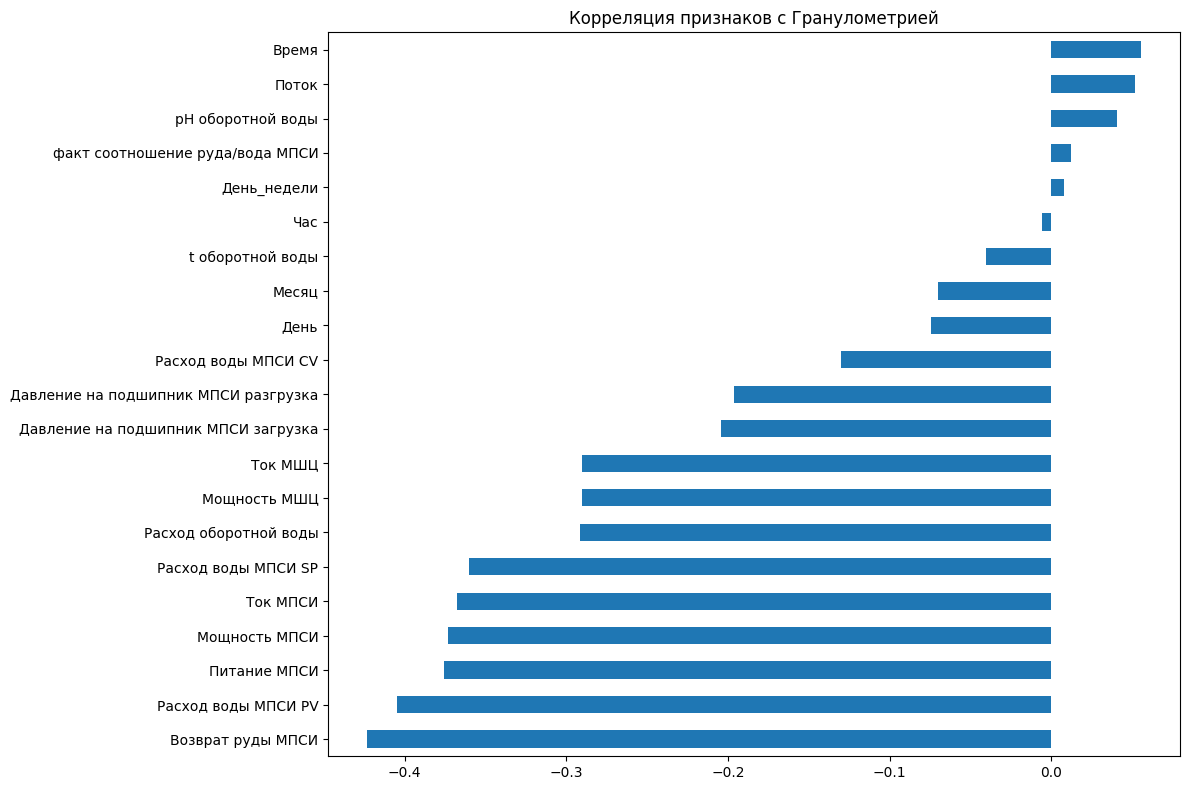

Топ-10 признаков по корреляции:
Расход воды МПСИ CV                0.130196
День                               0.074485
Месяц                              0.069847
Время                              0.055721
Поток                              0.051795
pH оборотной воды                  0.040433
t оборотной воды                   0.040070
факт соотношение руда/вода МПСИ    0.012417
День_недели                        0.007889
Час                                0.005768
dtype: float64


In [38]:
#  Корреляционный анализ на топ
plt.figure(figsize=(12, 8))
correlations = X.corrwith(y).sort_values(ascending=True)
correlations.plot(kind='barh')
plt.title('Корреляция признаков с Гранулометрией')
plt.tight_layout()
plt.show()

print('Топ-10 признаков по корреляции:')
print(correlations.abs().sort_values(ascending=False).tail(10))


## Рандом форестнадо сделать

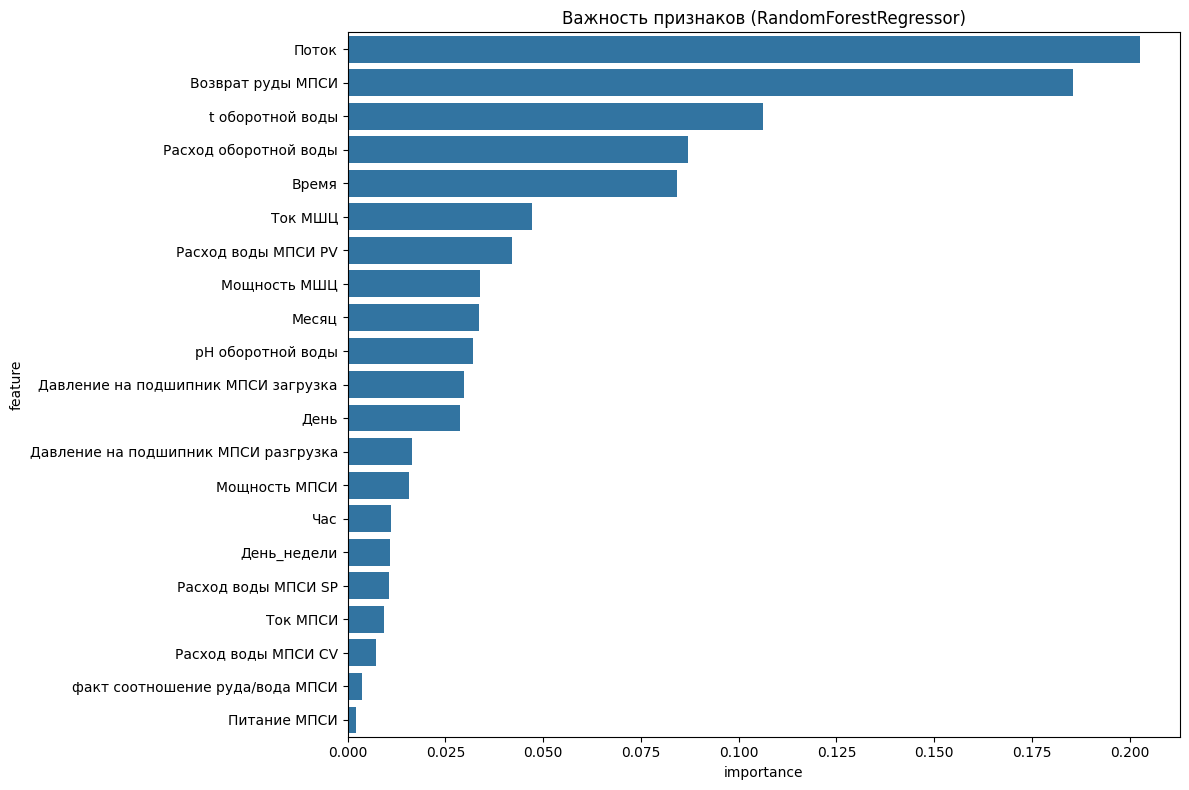


Топ-10 признаков по RandomForestRegressor:
                  feature  importance
16                  Поток    0.202703
6       Возврат руды МПСИ    0.185549
15       t оборотной воды    0.106217
13  Расход оборотной воды    0.087103
0                   Время    0.084145
4                 Ток МШЦ    0.047129
7     Расход воды МПСИ PV    0.042028
2            Мощность МШЦ    0.033870
19                  Месяц    0.033472
14      pH оборотной воды    0.031969


In [44]:
#  RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Важность признаков из RandomForestRegressor
gb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
gb_importance = gb_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=gb_importance)
plt.title('Важность признаков (RandomForestRegressor)')
plt.tight_layout()
plt.show()

print("\nТоп-10 признаков по RandomForestRegressor:")
print(gb_importance.head(10))